In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', creation_time=1667116190960, experiment_id='1', last_update_time=1667116190960, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
df = pd.read_parquet("./data/green_tripdata_2021-01.parquet")

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [5]:
# !pip install pyarrow

In [6]:
# !pip install fastparquet

In [7]:
def prepare_df(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)
        df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])
        df["lpep_dropoff_datetime"] = pd.to_datetime(df["lpep_dropoff_datetime"])
    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)
        
    df['duration'] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds()/60)
    df = df.loc[(df['duration']>=1) & (df['duration']<=60),:]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df
    
        

In [8]:
df_train = prepare_df('./data/green_tripdata_2022-01.parquet')
df_val = prepare_df('./data/green_tripdata_2022-02.parquet')

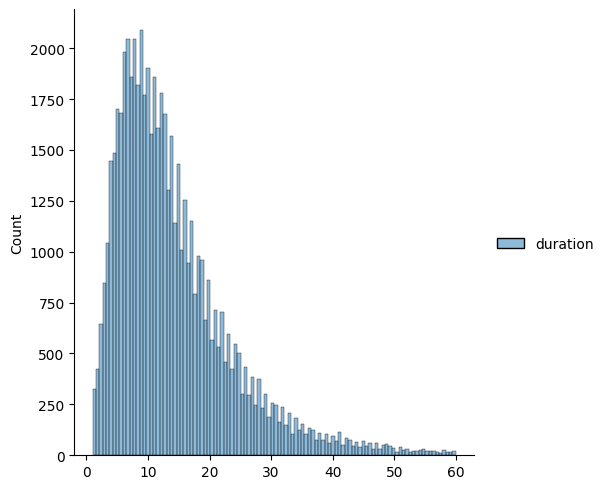

In [9]:
# Exploratory analysis

sns.displot(df_train.loc[((df_train['duration']>=1) & (df_train['duration']<=60)), ['duration']])

In [10]:
len(df_train), len(df_val)

(59603, 66097)

In [11]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59603 entries, 0 to 62494
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               59603 non-null  int64         
 1   lpep_pickup_datetime   59603 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  59603 non-null  datetime64[ns]
 3   store_and_fwd_flag     53367 non-null  object        
 4   RatecodeID             53367 non-null  float64       
 5   PULocationID           59603 non-null  object        
 6   DOLocationID           59603 non-null  object        
 7   passenger_count        53367 non-null  float64       
 8   trip_distance          59603 non-null  float64       
 9   fare_amount            59603 non-null  float64       
 10  extra                  59603 non-null  float64       
 11  mta_tax                59603 non-null  float64       
 12  tip_amount             59603 non-null  float64       
 13  t

In [13]:
categorical = ["PU_DO"]
numerical = ["trip_distance"]

dv = DictVectorizer()
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False)


6.92893123431991

In [16]:
lr = Lasso(0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

# Estimate RMSE
mean_squared_error(y_val, y_pred, squared = False)

7.475775217343405

In [17]:
import pickle

with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
lr = Ridge(0.1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False)

9.987741338419413

### mlflow lesso regression exp-tracking

In [19]:
with mlflow.start_run():
    
    mlflow.set_tag('developer', 'Rahul')
    mlflow.log_param('train-data-path', './data/green_tripdata_2022-01.parquet')
    mlflow.log_param('val-data-path', './data/green_tripdata_2022-02.parquet')
    
    alpha = 0.3
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared = False)
    mlflow.log_metric('rmse', rmse)
    
    mlflow.log_artifact(local_path="./models/lin_reg.bin", artifact_path='models_pickle')
    
    

In [20]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [21]:
train = xgb.DMatrix(X_train, label = y_train)
valid = xgb.DMatrix(X_val, label = y_val)

In [22]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 200,
            evals = [(valid, 'validation')],
            early_stopping_rounds = 50
        )
        
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric('rmse', rmse)
        
        
    return {'loss': rmse, 'status': STATUS_OK}



In [23]:


search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals = 10,
    trials = Trials()
)


[13:23:12] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:16.61948                          
[1]	validation-rmse:15.84868                          
[2]	validation-rmse:15.12608                          
[3]	validation-rmse:14.45182                          
[4]	validation-rmse:13.82281                          
[5]	validation-rmse:13.23801                          
[6]	validation-rmse:12.69192                          
[7]	validation-rmse:12.18495                          
[8]	validation-rmse:11.70822                          
[9]	validation-rmse:11.26973                          
[10]	validation-rmse:10.86317                         
[11]	validation-rmse:10.48398                         
[12]	validation-rmse:10.12900                         
[13]	validation-rmse:9.80551                          
[14]	validation-rmse:9.50332                          
[15]	validation-rmse:9.21767                          
[

### Saving the best model and preprocessor (dict_vectorizer) using artifact

##### Logging model in mlflow

Two Options
* Log model as an artifact

`mlflow.log_artifact("mymode", artifact_path = "models/")`

* Log model using the method log_model

`mlflow.<framework>.log_model(model, artifact_path = "models/)`

In [ ]:
# mlflow.xgboost.autolog(disable = True)

In [ ]:
best_params = {
'learning_rate': 0.5993284507408804,
'max_depth': 11,
'min_child_weight':	3.4193534403992176,
'objective': 'reg:linear',
'reg_alpha': 0.14482227632222044,
'reg_lambda': 0.010214875867722949,
'seed':	42
}

In [24]:
with mlflow.start_run():
    
    best_params = {
        'learning_rate': 0.5993284507408804,
        'max_depth': 11,
        'min_child_weight':	3.4193534403992176,
        'objective': 'reg:linear',
        'reg_alpha': 0.14482227632222044,
        'reg_lambda': 0.010214875867722949,
        'seed':	42
    }
        
    mlflow.log_params(best_params)
    
    booster = xgb.train(
        params = best_params,
        dtrain = train,
        num_boost_round = 1000,
        evals = [(valid, 'validation')],
        early_stopping_rounds = 50
    )
        
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)
    
    with open("models/preprocessor.b", 'wb') as f_out:
        pickle.dump(dv, f_out)
    
    mlflow.log_artifact('models/preprocessor.b', artifact_path = 'preprocessor')
    mlflow.xgboost.log_model(booster, artifact_path = "models_mlflow")

[13:42:30] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:9.30476
[1]	validation-rmse:6.89501
[2]	validation-rmse:6.25933
[3]	validation-rmse:6.08787
[4]	validation-rmse:6.03321
[5]	validation-rmse:6.00181
[6]	validation-rmse:5.98581
[7]	validation-rmse:5.97882
[8]	validation-rmse:5.97381
[9]	validation-rmse:5.96944
[10]	validation-rmse:5.96411
[11]	validation-rmse:5.95796
[12]	validation-rmse:5.95499
[13]	validation-rmse:5.95360
[14]	validation-rmse:5.94911
[15]	validation-rmse:5.94147
[16]	validation-rmse:5.93166
[17]	validation-rmse:5.92809
[18]	validation-rmse:5.92634
[19]	validation-rmse:5.92604
[20]	validation-rmse:5.92402
[21]	validation-rmse:5.91994
[22]	validation-rmse:5.91390
[23]	validation-rmse:5.91128
[24]	validation-rmse:5.90776
[25]	validation-rmse:5.90554
[26]	validation-rmse:5.90153
[27]	validation-rmse:5.89770
[28]	validation-rmse:5.89593
[29]	validation-rmse:5.89502
[30]	validation-rmse:

/home/rahul-raoniar/miniconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### Loading model from mlflow to make prediction

In [25]:
import mlflow
logged_model = 'runs:/f7836a9cd7fd4d06b6c89020443e68b2/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)



[13:44:11] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [26]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: f7836a9cd7fd4d06b6c89020443e68b2

### Loading model using xgboost specific flavor

In [27]:
# Loading another way
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

[13:44:18] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [28]:
y_pred = xgboost_model.predict(valid)
y_pred[0:10]

array([ 7.1365967,  3.8544457, 26.631983 , 36.277954 , 29.04246  ,
        9.269173 , 19.679651 ,  4.2602587, 14.964005 ,  5.7357306],
      dtype=float32)

### Model Registry

In [29]:

from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

### Interacting with the MLflow tracking server

The MlflowClient object allows us to interact with...

* an MLflow Tracking Server that creates and manages experiments and runs.
* an MLflow Registry Server that creates and manages registered models and model versions.


In [30]:
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

client.list_experiments()

/tmp/ipykernel_10839/1734911439.py:3: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  client.list_experiments()


[<Experiment: artifact_location='./mlruns/0', creation_time=1667116190884, experiment_id='0', last_update_time=1667116190884, lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='./mlruns/1', creation_time=1667116190960, experiment_id='1', last_update_time=1667116190960, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>]

In [31]:
# Lets create a new experiment

client.create_experiment(name = "my-cool-experiment")

'2'

Let's check the latest versions for the experiment with id 1

In [32]:
from mlflow.entities import ViewType

In [33]:
runs = client.search_runs(
    experiment_ids='1',
    filter_string='metrics.rmse < 7',
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
)

In [34]:
for run in runs:
    print(f"run id {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id 2c20da9f9cba4025b5aecee7aa1aa9a8, rmse: 5.8312
run id f7836a9cd7fd4d06b6c89020443e68b2, rmse: 5.8363
run id 6640e99825bb4a8fb7716c6d4e75ba5d, rmse: 5.8524
run id cbd3b10f3d7e4dbfa44e28aa5a8207bc, rmse: 5.8726
run id 88434dae3b524c6787cb619334a1a57e, rmse: 5.8995



### Interacting with the Model Registry

In this section We will use the MlflowClient instance to:

1. Register a new version for the experiment nyc-taxi-regressor
2. Retrieve the latests versions of the model nyc-taxi-regressor and check that a new version 4 was created.
3. Transition the version 4 to "Staging" and adding annotations to it.



In [35]:
import mlflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [36]:
run_id = '2c20da9f9cba4025b5aecee7aa1aa9a8'
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri = model_uri,
                      name = 'nyc-taxi-regressor')


Successfully registered model 'nyc-taxi-regressor'.
2022/10/30 13:46:07 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: nyc-taxi-regressor, version 1
Created version '1' of model 'nyc-taxi-regressor'.


<ModelVersion: creation_timestamp=1667117767792, current_stage='None', description=None, last_updated_timestamp=1667117767792, name='nyc-taxi-regressor', run_id='2c20da9f9cba4025b5aecee7aa1aa9a8', run_link=None, source='./mlruns/1/2c20da9f9cba4025b5aecee7aa1aa9a8/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [37]:
model_name = 'nyc-taxi-regressor'
latest_version = client.get_latest_versions(name = model_name)

for version in latest_version:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: None


In [38]:
### Adding to a new area

model_version = 1
new_stage = "Staging"
client.transition_model_version_stage(
    name = model_name,
    version = model_version,
    stage = new_stage,
    archive_existing_versions=False
)

<ModelVersion: creation_timestamp=1667117767792, current_stage='Staging', description=None, last_updated_timestamp=1667117785865, name='nyc-taxi-regressor', run_id='2c20da9f9cba4025b5aecee7aa1aa9a8', run_link=None, source='./mlruns/1/2c20da9f9cba4025b5aecee7aa1aa9a8/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [44]:

# Adding a description

from datetime import datetime

date = datetime.today().date()
client.update_model_version(
    name=model_name,
    version = model_version,
    description= f"The model version {model_version} was transitioned to {new_stage} on {date}"
)

<ModelVersion: creation_timestamp=1667117767792, current_stage='Staging', description='The model version 1 was transitioned to Staging on 2022-10-30', last_updated_timestamp=1667117962972, name='nyc-taxi-regressor', run_id='2c20da9f9cba4025b5aecee7aa1aa9a8', run_link=None, source='./mlruns/1/2c20da9f9cba4025b5aecee7aa1aa9a8/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

### Adding this model to production as Version 2 for nyc_taxi_regressor model

So we retrained the nyc taxi regression model and now we want to add it in model registry under the 'nyc-taxi-regressor' model name as version 2 model


In [39]:
# Adding this model id to 'nyc-taxi-regressor' model registry

run_id = 'f7836a9cd7fd4d06b6c89020443e68b2'
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri = model_uri,
                      name = 'nyc-taxi-regressor')

Registered model 'nyc-taxi-regressor' already exists. Creating a new version of this model...
2022/10/30 13:47:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: nyc-taxi-regressor, version 2
Created version '2' of model 'nyc-taxi-regressor'.


<ModelVersion: creation_timestamp=1667117866604, current_stage='None', description=None, last_updated_timestamp=1667117866604, name='nyc-taxi-regressor', run_id='f7836a9cd7fd4d06b6c89020443e68b2', run_link=None, source='./mlruns/1/f7836a9cd7fd4d06b6c89020443e68b2/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [40]:
# Check the version assigned

model_name = 'nyc-taxi-regressor'
latest_version = client.get_latest_versions(name = model_name)

for version in latest_version:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: Staging
version: 2, stage: None


In [51]:
# Sending version 3 to production
model_version = 2
new_stage = "Production"
client.transition_model_version_stage(
    name = model_name,
    version = model_version,
    stage = new_stage,
    archive_existing_versions=False
)

<ModelVersion: creation_timestamp=1667117866604, current_stage='Production', description='The model version 2 was transitioned to Staging on 2022-10-30', last_updated_timestamp=1667118241213, name='nyc-taxi-regressor', run_id='f7836a9cd7fd4d06b6c89020443e68b2', run_link=None, source='./mlruns/1/f7836a9cd7fd4d06b6c89020443e68b2/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [54]:
# Check the version assigned

model_name = 'nyc-taxi-regressor'
latest_version = client.get_latest_versions(name = model_name)

for version in latest_version:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: Staging
version: 2, stage: Production


In [43]:
# Update description
from datetime import datetime

date = datetime.today().date()
client.update_model_version(
    name = model_name,
    version = model_version,
    description = f"The model version {model_version} was transitioned to {new_stage} on {date}"
)

<ModelVersion: creation_timestamp=1667117866604, current_stage='Staging', description='The model version 2 was transitioned to Staging on 2022-10-30', last_updated_timestamp=1667117927422, name='nyc-taxi-regressor', run_id='f7836a9cd7fd4d06b6c89020443e68b2', run_link=None, source='./mlruns/1/f7836a9cd7fd4d06b6c89020443e68b2/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

### Lets check the performance of version 1 model so that we can add it to production


In [45]:
def read_dataframe(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)
        df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])
        df["lpep_dropoff_datetime"] = pd.to_datetime(df["lpep_dropoff_datetime"])
    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)
        
    df['duration'] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds()/60)
    df = df.loc[(df['duration']>=1) & (df['duration']<=60),:]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

def preprocess(df, dv):
    df["PU_DO"] = df["PULocationID"] + "_" + df["DOLocationID"]
    categorical = ["PU_DO"]
    numerical = ["trip_distance"]
    train_dicts = df[categorical + numerical].to_dict(orient = 'records')
    return dv.transform(train_dicts)

def test_model(stage, X_test, y_test, name = 'nyc-taxi-regressor'):
    model = mlflow.pyfunc.load_model(f"models:/{name}/{stage}")
    y_pred = model.predict(X_test)
    return {'rmse': mean_squared_error(y_test, y_pred, squared=False)}


In [46]:
df = read_dataframe('data/green_tripdata_2021-03.parquet')

In [47]:
import pickle

with open('models/preprocessor.b', 'rb') as f_in:
    dv = pickle.load(f_in)

In [48]:
X_test = preprocess(df, dv)

In [49]:
target = 'duration'
y_test = df[target].values

In [53]:
%time test_model(name = model_name, stage = "Production", X_test = X_test, y_test = y_test)

OSError: No such file or directory: './mlruns/1/f7836a9cd7fd4d06b6c89020443e68b2/artifacts/model/.'

In [66]:
import mlflow
logged_model = 'runs:/f7836a9cd7fd4d06b6c89020443e68b2/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

[14:31:36] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
